In [1]:
from elasticsearch import Elasticsearch, helpers
import pandas as pd
import matplotlib.pyplot as plt
import configparser
import matplotlib.dates as mdates


In [2]:
ELASTIC_SEARCH_HOSTS = [
    "https://172.26.170.253:9200/",
    "https://172.26.170.156:9200/",
    "https://172.26.170.52:9200/",
    "https://172.26.170.20:9200/",
    "https://172.26.170.185:9200/",
    "https://172.26.170.249:9200/",
    "https://172.26.170.132:9200/",
    "https://172.26.170.208:9200/",
    "https://172.26.170.33:9200/",
    "https://172.26.170.109:9200/",
]

In [3]:
def get_client():
    config = configparser.ConfigParser()
    config.read("../elastic/security.ini")
    client = Elasticsearch(
                ELASTIC_SEARCH_HOSTS,
                ca_certs='../elastic/http_ca.crt',
                basic_auth=(config["ELASTIC"]["user"], config["ELASTIC"]["password"]),
                verify_certs=True,
                retry_on_timeout=True,
                max_retries=3,
            )   
    if client.ping():
        print("Connected to Elasticsearch.")
        return client
    print("Could not connect to Elasticsearch.")
    return client

def get_data(index, es):
    # Elasticsearch query to fetch all documents from indices matching pattern
    query = {
        "query": {"match_all": {}}
    }
    # Fetch all data with scroll API
    results = helpers.scan(es, index=index, query=query)
    # Convert to pandas DataFrame
    data = [doc["_source"] for doc in results]
    return pd.DataFrame(data)

In [4]:
es = get_client()  
idle_df = get_data("aggregated-curr-udplatency-*", es)
up_lul = get_data("aggregated-curr-ulping-*", es)
down_lul = get_data("aggregated-curr-dlping-*", es)

Connected to Elasticsearch.


In [9]:
def plot_for_tech(df_dict, percentile, name):
    plt.figure(figsize=(12, 6))
    for label, data in df_dict.items():
        grouped = data.groupby('year_month')['rtt_avg'].quantile(percentile/100).sort_index()
        plt.plot(grouped.index, grouped.values, label=label)
    
    if percentile == 5:
        title = '5th Percentile of Latency by Year'
        perc = '5th-percentile'
    elif percentile == 1:
        title = '1st Percentile of Latency by Year'
        perc = '1st-percentile'
    elif percentile == 95:
        title = '95th Percentile of Latency by Year'
        perc = '95th-percentile'

    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Latency (ms)')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./plots/latency/low_perf_tiers/{name}-{perc}.png')
    plt.show()


def plot_percentiles(df, title):
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()

    filters = {
        'All': df,
        'Fiber': df[df['operator_technology'] == 'Fiber'],
        'DSL': df[df['operator_technology'] == 'DSL'],
        'Cable': df[df['operator_technology'] == 'Cable']
    }

    # ----- First Plot: 5th Percentile -----
    plot_for_tech(filters, 5, title)

    # ----- Second Plot: 1st Percentile -----
    plot_for_tech(filters, 1, title)

    # ----- Third Plot: 95th Percentile -----
    plot_for_tech(filters, 95, title)

/tmp/ipykernel_54142/1369209328.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()


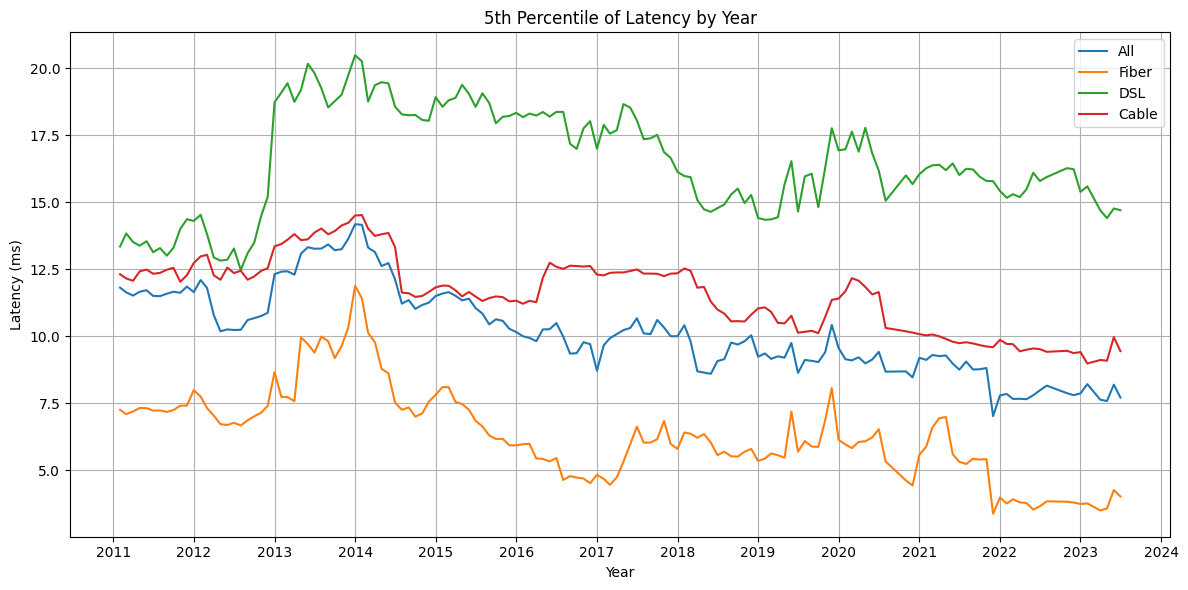

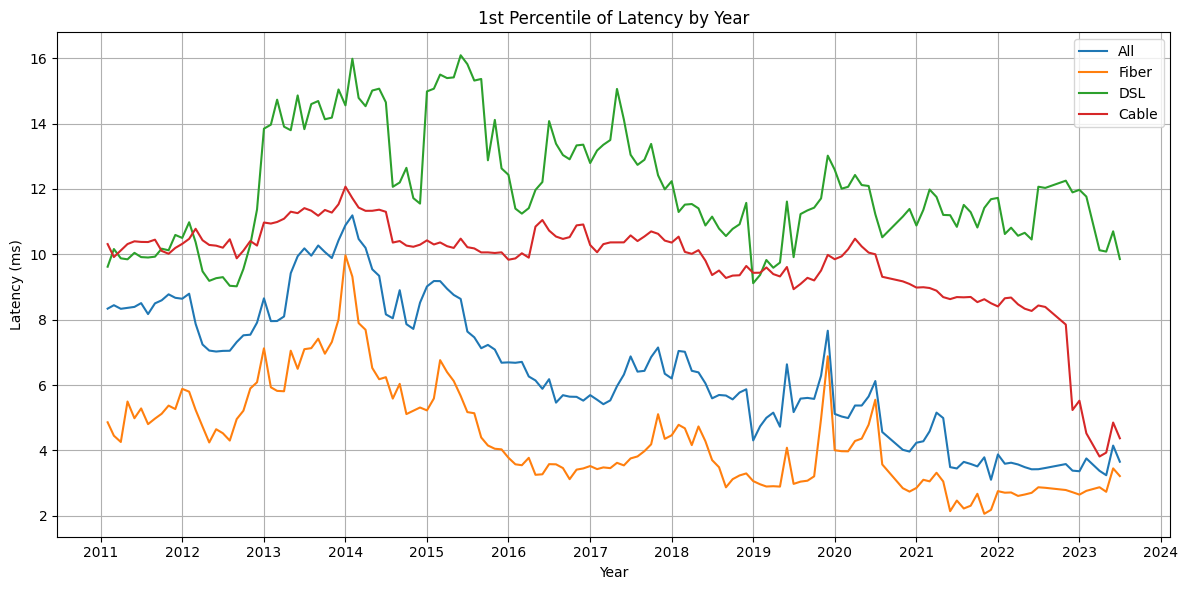

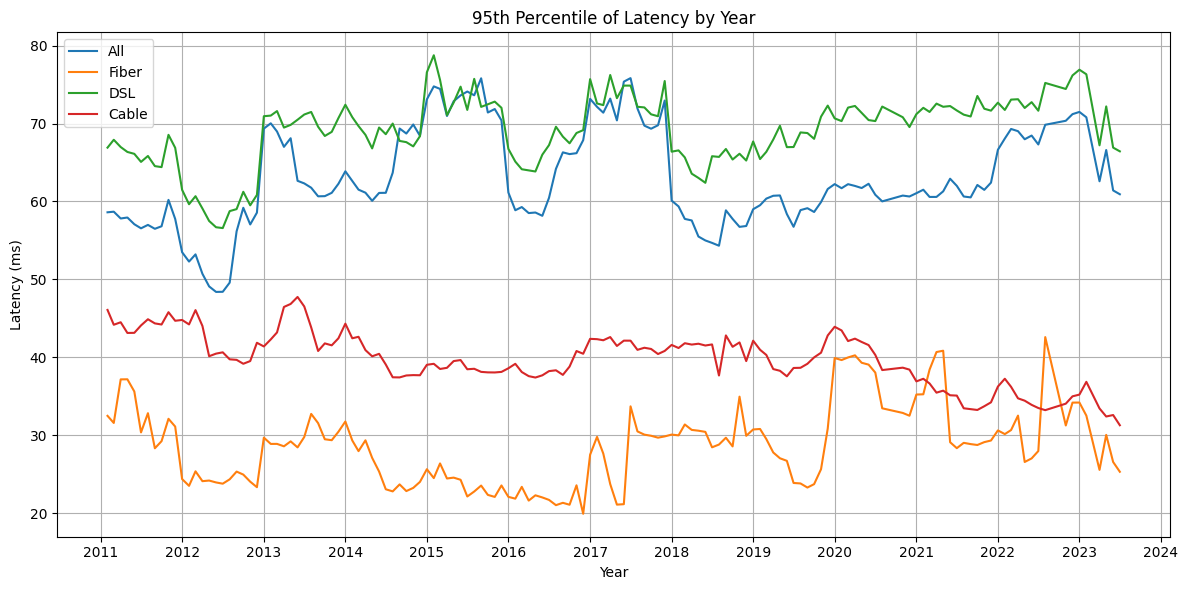

In [10]:
plot_percentiles(idle_df, 'idle_lat')

/tmp/ipykernel_54142/1369209328.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()


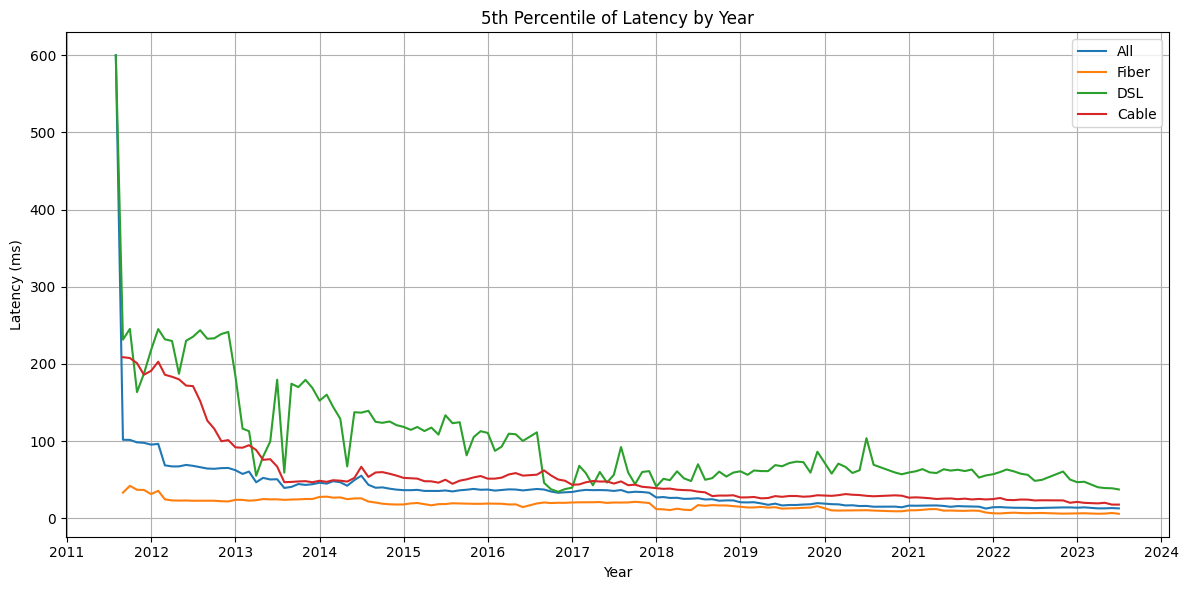

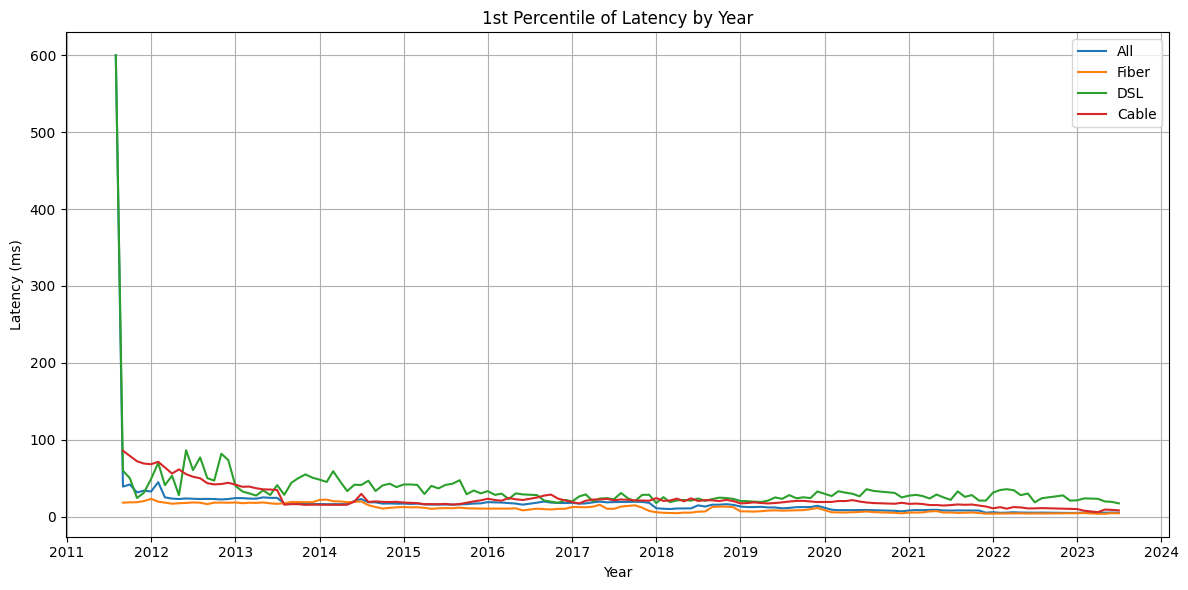

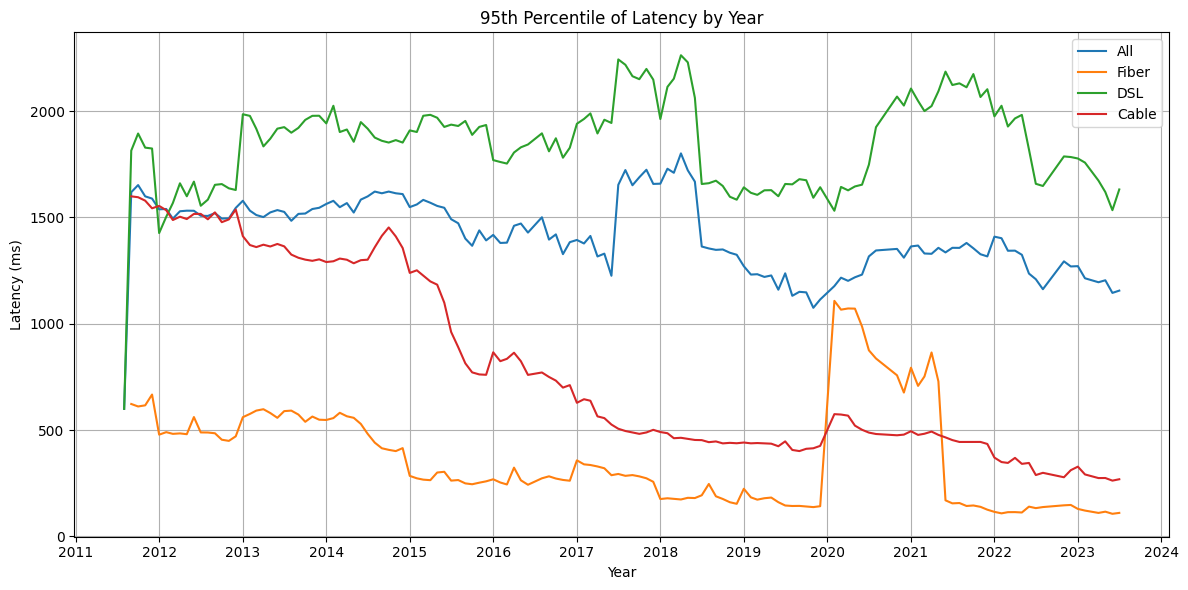

In [11]:
plot_percentiles(up_lul, 'up_lul')

/tmp/ipykernel_54142/1369209328.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()


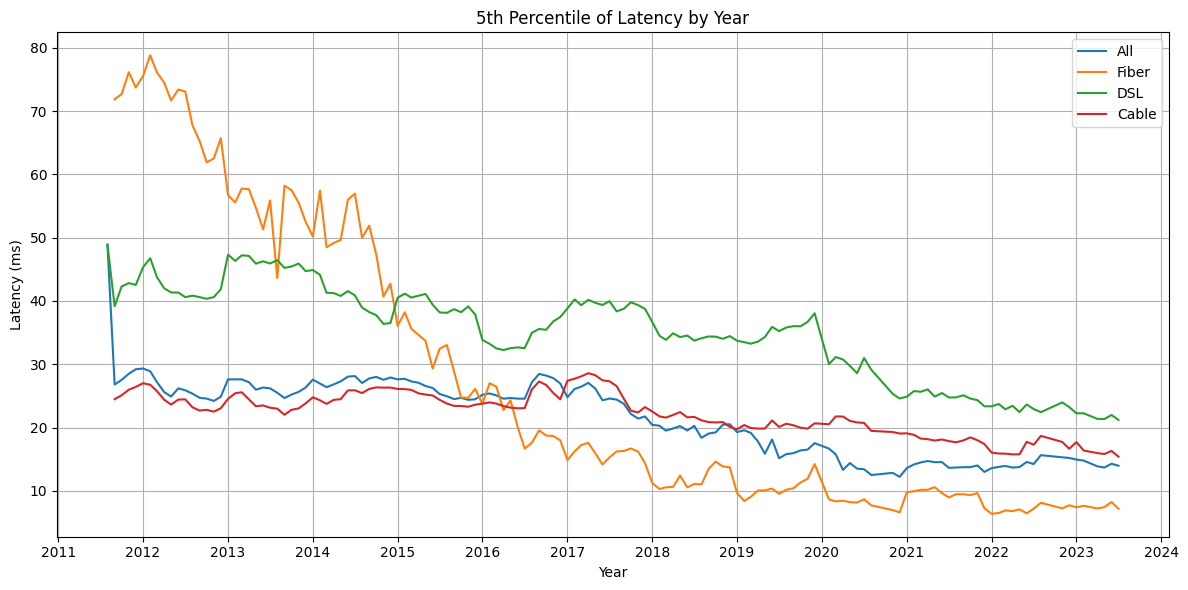

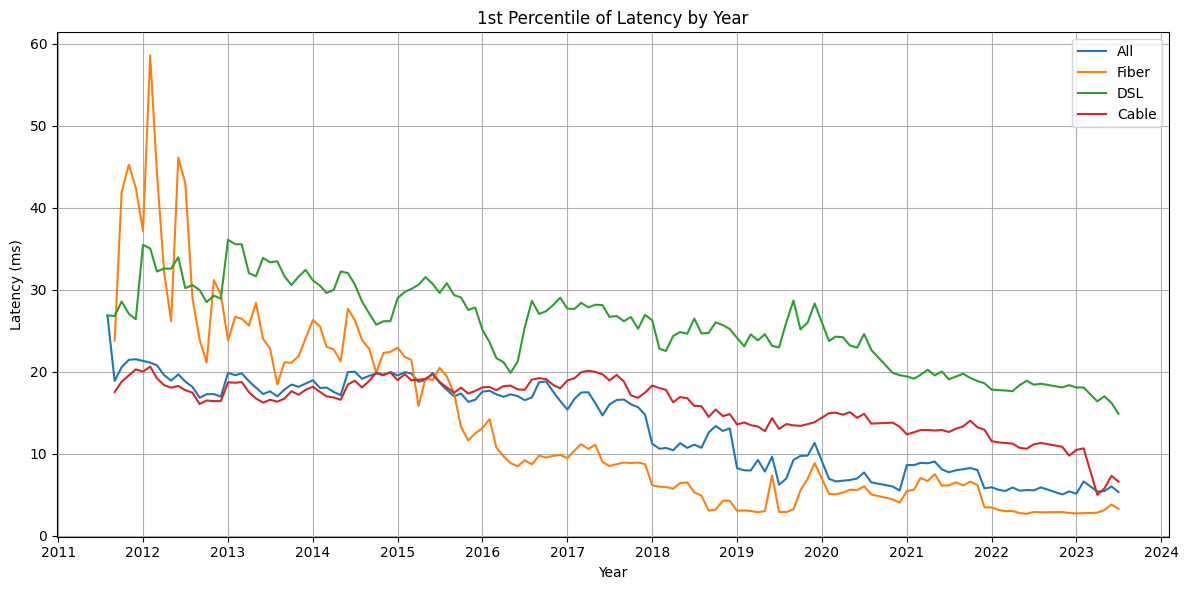

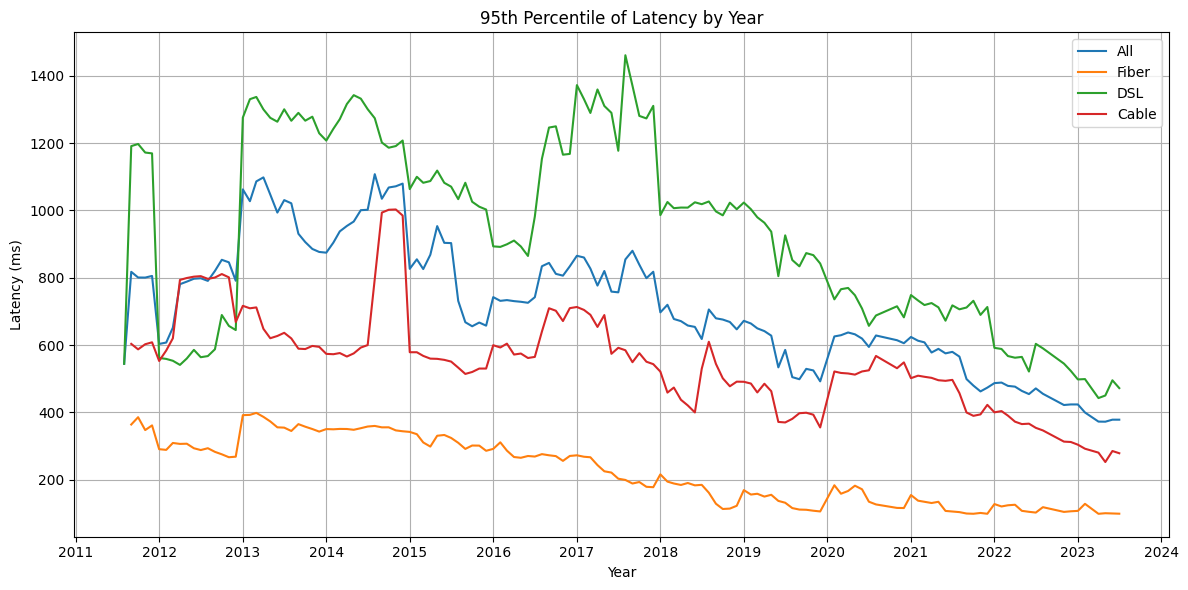

In [12]:
plot_percentiles(down_lul, 'down_lul')